# Unsupervised Learning : t-distributed stochastic neighbour embedding (t-SNE)

High-dimension dataset is common in physics. Visualization of data is a very relevant issue and t-SNE is a robust method to represent the data in a much fewer dimension manner. Given dataset ${\vec{x}_{1},\vec{x}_{2},...,\vec{x}_{M}}$ with $\vec{x}_{i}\in \mathbb{R}^{N}$. We want to find a new representation that manifests few key features of this dataset. Let the new representation be ${\vec{x}'_{1},\vec{x}'_{2},...,\vec{x}'_{M}}$ with $\vec{x}'_{i}\in \mathbb{R}^{N'}$ and N'=2 or 3 in our special case so that we can visualize the features.

For original representation of data, we define similarity function by Gaussian distribution of any two data points as 

$p(j|i)=\frac{exp(-|\vec{x}_{i}-\vec{x}_{j}|^{2}/2\sigma_{i}^{2})}{\sum_{k\neq i}exp(-|\vec{x}_{i}-\vec{x}_{k}|^{2}/2\sigma_{i}^{2})}$

For new representation of data, we hope to reach a similarity function $g(j|i)$ of some suggestive form that when we minimize cost function of the KL-divergence, new representation $\vec{x}'_{1},\vec{x}'_{2},...,\vec{x}'_{M}$ will be adjusted or iteratively updated such that $g(j|i)$ will preserve the structure of p(j|i).  

$C=\sum_{i}KL(P_{i}||Q_{i})=\sum_{i}\sum_{j} p(j|i) log(\frac{p(j|i)}{q(j|i)})$

In [7]:
import numpy as np
import pylab

In [10]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = max(sum(P),1e-10)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [3]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

In [4]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


In [11]:
def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

In [6]:
x_ising_20 = np.loadtxt( 'spinConfigs_Ising_L20 copy.txt' , dtype='int8' )
t_ising_20 = np.loadtxt( 'temperatures_Ising_L20 copy.txt' , dtype='int8' )
x_ising_40 = np.loadtxt( 'spinConfigs_Ising_L40 copy.txt' , dtype='int8' )
t_ising_40 = np.loadtxt( 'temperatures_Ising_L40 copy.txt' , dtype='int8' )
x_ising_80 = np.loadtxt( 'spinConfigs_Ising_L80 copy.txt' , dtype='int8' )
t_ising_80 = np.loadtxt( 'temperatures_Ising_L80 copy.txt' , dtype='int8' )
x_gauge_20 = np.loadtxt( 'spinConfigs_gaugeTheory_L20 copy.txt' , dtype='int8' )
t_gauge_20 = np.loadtxt( 'labels_gaugeTheory_L20 copy.txt' , dtype='int8' )
x_gauge_40 = np.loadtxt( 'spinConfigs_gaugeTheory_L40 copy.txt' , dtype='int8' )
t_gauge_40 = np.loadtxt( 'labels_gaugeTheory_L40 copy.txt' , dtype='int8' )
x_gauge_80 = np.loadtxt( 'spinConfigs_gaugeTheory_L80 copy.txt' , dtype='int8' )
t_gauge_80 = np.loadtxt( 'labels_gaugeTheory_L80 copy.txt' , dtype='int8' )

In [8]:
y_ising_20 = tsne(x_ising_20, 2, x_ising_20.shape[1], 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 2.000830
Iteration 10: error is 14.616644
Iteration 20: error is 13.554323
Iteration 30: error is 11.923448
Iteration 40: error is 11.927173
Iteration 50: error is 12.008299
Iteration 60: error is 12.123215
Iteration 70: error is 12.142178
Iteration 80: error is 12.126945
Iteration 90: error is 12.115285
Iteration 100: error is 12.113202
Iteration 110: error is 1.548673
Iteration 120: error is 1.382215
Iteration 130: error is 1.256371
Iteration 140: error is 1.204305
Iteration 150: error is 1.177588
Iteration 160: error is 1.160391
Iteration 170: error is 1.148001
Iteration 180: error is 1.139935
Iteration 190: error is 1.134703
Iteration 200: error is 1.131039
Iteration 210: error is 1.128652
Iteration 220: error is 1.126905

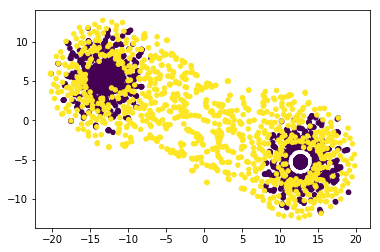

In [16]:
pylab.scatter(y_ising_20[:, 0], y_ising_20[:, 1], 20, t_ising_20)
pylab.show()

In [12]:
y_ising_40 = tsne(x_ising_40, 2, x_ising_40.shape[1], 30.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 4.453033


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater


Iteration 10: error is nan
Iteration 20: error is nan
Iteration 30: error is nan
Iteration 40: error is nan
Iteration 50: error is nan
Iteration 60: error is nan
Iteration 70: error is nan
Iteration 80: error is nan
Iteration 90: error is nan
Iteration 100: error is nan
Iteration 110: error is nan
Iteration 120: error is nan
Iteration 130: error is nan
Iteration 140: error is nan
Iteration 150: error is nan
Iteration 160: error is nan
Iteration 170: error is nan
Iteration 180: error is nan
Iteration 190: error is nan
Iteration 200: error is nan
Iteration 210: error is nan
Iteration 220: error is nan
Iteration 230: error is nan
Iteration 240: error is nan
Iteration 250: error is nan
Iteration 260: error is nan
Iteration 270: error is nan
Iteration 280: error is nan
Iteration 290: error is nan
Iteration 300: error is nan
Iteration 310: error is nan
Iteration 320: error is nan
Iteration 330: error is nan
Iteration 340: error is nan
Iteration 350: error is nan
Iteration 360: error is nan
I

In [ ]:
y_ising_80 = tsne(x_ising_80, 2, x_ising_80.shape[1], 30.0)

In [21]:
y_gauge_20 = tsne(x_gauge_20, 2, x_gauge_20.shape[1], 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 6.503270
Iteration 10: error is 9.145015
Iteration 20: error is 9.144515
Iteration 30: error is 9.144511
Iteration 40: error is 9.144510
Iteration 50: error is 9.144510
Iteration 60: error is 9.144510
Iteration 70: error is 9.144510
Iteration 80: error is 9.144510
Iteration 90: error is 9.144510
Iteration 100: error is 9.144510
Iteration 110: error is 0.899833
Iteration 120: error is 0.899832
Iteration 130: error is 0.892581
Iteration 140: error is 0.883142
Iteration 150: error is 0.881547
Iteration 160: error is 0.880879
Iteration 170: error is 0.880578
Iteration 180: error is 0.880386
Iteration 190: error is 0.880217
Iteration 200: error is 0.880108
Iteration 210: error is 0.880045
Iteration 220: error is 0.879947
Iteration 230: error is 0.879793
Iteration 240: error is 0.879643
Iteration 250: error is 0.879491


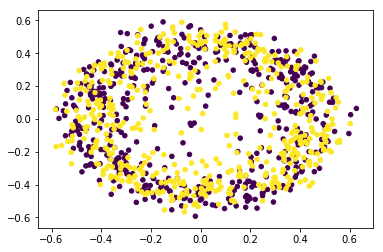

In [22]:
pylab.scatter(y_gauge_20[:, 0], y_gauge_20[:, 1], 20, t_gauge_20)
pylab.show()

In [23]:
y_gauge_40 = tsne(x_gauge_40, 2, x_gauge_40.shape[1], 20.0)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1000...
Computing P-values for point 500 of 1000...
Mean value of sigma: 13.122383
Iteration 10: error is 6.404946
Iteration 20: error is 6.404349
Iteration 30: error is 6.404348
Iteration 40: error is 6.404348
Iteration 50: error is 6.404348
Iteration 60: error is 6.404348
Iteration 70: error is 6.404348
Iteration 80: error is 6.404348
Iteration 90: error is 6.404348
Iteration 100: error is 6.404348
Iteration 110: error is 0.214793
Iteration 120: error is 0.214793
Iteration 130: error is 0.214792
Iteration 140: error is 0.214638
Iteration 150: error is 0.213198
Iteration 160: error is 0.212756
Iteration 170: error is 0.212625
Iteration 180: error is 0.212566
Iteration 190: error is 0.212526
Iteration 200: error is 0.212493
Iteration 210: error is 0.212465
Iteration 220: error is 0.212438
Iteration 230: error is 0.212414
Iteration 240: error is 0.212394
Iteration 250: error is 0.212381

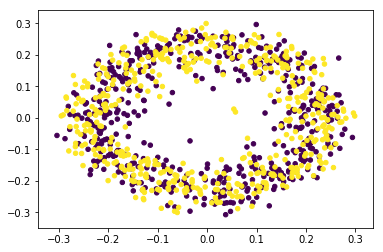

In [24]:
pylab.scatter(y_gauge_40[:, 0], y_gauge_40[:, 1], 20, t_gauge_40)
pylab.show()

In [ ]:
#if __name__ == "__main__":
#    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
#    print("Running example on 2,500 MNIST digits...")
#    X = np.loadtxt("mnist2500_X.txt")
#    labels = np.loadtxt("mnist2500_labels.txt")
#    Y = tsne(X, 2, 50, 20.0)
#    pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#    pylab.show()
    